# ⚠️Make sure to select hand segmentation as kernel⚠️

# Setup Dataset Class

In [18]:
import os
import numpy as np
import torch
from PIL import Image, ImageDraw
import cv2  # Not actually necessary if you just want to create an image.
import numpy as np
from matplotlib import pyplot as plt
import json
import os
import operator

class HandsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        f = open('/scratch/ndillenb/json_hand_segmentation.json')
        data = json.load(f)
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages1"))))
        self.masks = list(sorted(data['samples'],  key=operator.itemgetter('imageUrl'))) #REMOVE MASKS

    def __getitem__(self, idx):
        # load images and masks
        #f = open('/scratch/ndillenb/json_hand_segmentation.json')
        #data = json.load(f)
        img_path = os.path.join(self.root, "PNGImages1", self.imgs[idx])
        mask_json = self.masks[idx]
        #mask_path = os.path.join(self.root, "PedMasks_seg", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        w,h = img.size
        all_polygon = []
        i = 0
        im = Image.new("L", (w,h), 0)
        all_polygon = []
        for shape in mask_json['annotation']:
            i = i+1
            polygon = tuple()
            for point in shape['points']:
                new_x = point['x']*w
                new_y = point['y']*h
                point = tuple([new_x,new_y])
                polygon=polygon+point
            all_polygon.append(polygon)
            ImageDraw.Draw(im).polygon(polygon, outline=i,fill=i)
        mask = np.array(im)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(mask_json['annotation'])
        boxes = []
        #print(self.masks[idx])
        #print(num_objs)
        for element in all_polygon:
            xmax = np.max(element[::2])
            ymax = np.max(element[1::2])
            xmin = np.min(element[::2])
            ymin = np.min(element[1::2])
            boxes.append([xmin, ymin, xmax, ymax])
        #for i in range(num_objs):
            #pos = np.where(masks[i])
            #xmin = np.min(pos[1])
            #xmax = np.max(pos[1])
            #ymin = np.min(pos[0])
            #ymax = np.max(pos[0])
            #if ((xmin != xmax) and (ymin != ymax)):
                #boxes.append([xmin, ymin, xmax, ymax])
            #print(boxes[i])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        #print(img_path)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)#weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [20]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [21]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [22]:
import transforms  as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [23]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = HandsDataset('Hands_dataset', get_transform(train=True))
dataset_test = HandsDataset('Hands_dataset', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-20])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=25,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=25,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.01)



In [24]:
from io import StringIO
import sys
import matplotlib.pyplot as plt

def plot_loss(loss_metrics,num_epochs):
    y=[]
    x = [i for i in range(1, num_epochs+1)]
    for loss in loss_metrics:
        y.append(loss.meters['loss'].avg)
    plt.plot(x,y)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    

def plot_F1(evaluation):
    old_stdout = sys.stdout
    output = StringIO()
    sys.stdout = output
    printed_text = []
    for element in evaluation:
        element.summarize()
        printed_text.append(output.getvalue())
        output = StringIO()
        sys.stdout = output
    # Restore stdout to the console
    sys.stdout = old_stdout
    F1_all = []
    AR_all = []
    AP_all = []
    for element in printed_text:
        i = 0
        AP = []
        AR = []
        F1 = []
        for element_txt in element.splitlines():
            if (i > 13) and (i < 20):
                #print(element_txt[74:])
                AP.append(float(element_txt[74:]))
            if (i > 13) and (i > 19) and (i<26):
                #print(element_txt[74:])
                AR.append(float(element_txt[74:]))
            i=i+1
        for i in range(len(AP)):
            try: 
                F1.append(2*AP[i]*AR[i]/(AP[i]+AR[i]))
            except ZeroDivisionError:
                F1.append('nan')
        #print(F1)
        F1_all.append(F1)
        AR_all.append(AR)
        AP_all.append(AP)
    txt = ['IoU=0.50:0.95 | area=   all','IoU=0.50      | area=   all', 'IoU=0.75      | area=   all','IoU=0.50:0.95 | area= small','IoU=0.50:0.95 | area=medium','IoU=0.50:0.95 | area= large']
    x = [i for i in range(1, num_epochs+1)]
    plt.rcParams['figure.figsize'] = [7, 4]
    fig, axs = plt.subplots(3,2,constrained_layout = True)
    axs_all = [axs[0][0],axs[0][1],axs[1][0],axs[1][1],axs[2][0],axs[2][1]]
    for i in range(len(F1_all[0])):
            y = []
            for j in range(len(F1_all)):
                if F1_all[j][i]=='nan':
                    y.append(0)
                else:
                    y.append(F1_all[j][i])
            axs_all[i].set_title(txt[i])
            axs_all[i].set_xlabel('epoch - axis')
            axs_all[i].set_ylabel('F1 score')
            axs_all[i].plot(x,y)

# Train model

Epoch: [0]  [ 0/53]  eta: 0:02:08  lr: 0.000101  loss: 4.2649 (4.2649)  loss_classifier: 0.7749 (0.7749)  loss_box_reg: 0.1049 (0.1049)  loss_mask: 3.3459 (3.3459)  loss_objectness: 0.0280 (0.0280)  loss_rpn_box_reg: 0.0113 (0.0113)  time: 2.4167  data: 1.5304  max mem: 4347
Epoch: [0]  [52/53]  eta: 0:00:00  lr: 0.005000  loss: 0.5451 (0.9786)  loss_classifier: 0.0914 (0.1837)  loss_box_reg: 0.1666 (0.1652)  loss_mask: 0.2395 (0.6022)  loss_objectness: 0.0089 (0.0223)  loss_rpn_box_reg: 0.0036 (0.0052)  time: 0.5883  data: 0.0025  max mem: 4347
Epoch: [0] Total time: 0:00:33 (0.6302 s / it)
evaluate
creating index...
index created!
Test:  [ 0/20]  eta: 0:00:33  model_time: 0.1571 (0.1571)  evaluator_time: 0.0366 (0.0366)  time: 1.6565  data: 1.4604  max mem: 4347
Test:  [19/20]  eta: 0:00:00  model_time: 0.1274 (0.1419)  evaluator_time: 0.0142 (0.0260)  time: 0.2443  data: 0.0745  max mem: 4347
Test: Total time: 0:00:05 (0.2513 s / it)
Averaged stats: model_time: 0.1274 (0.1419)  eval

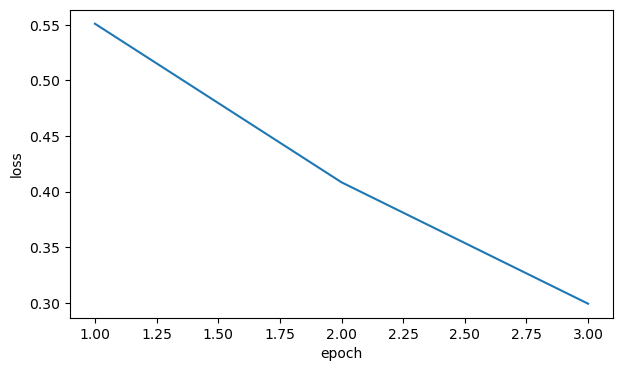

That's it!


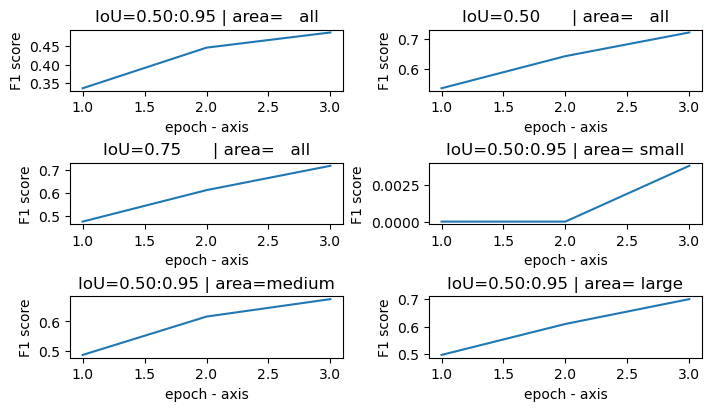

In [25]:
# let's train it for 1000 epochs
num_epochs = 3
evaluation = []
loss_metrics = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    loss_metrics.append(train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=54))
    # update the learning rate
    lr_scheduler.step()
    print('evaluate')
    # evaluate on the test dataset
    evaluation.append(evaluate(model, data_loader_test, device=device))
plot_loss(loss_metrics,num_epochs)
plot_F1(evaluation)
print("That's it!")

# Show metrics

## Plot F1

## Plot AR-AP

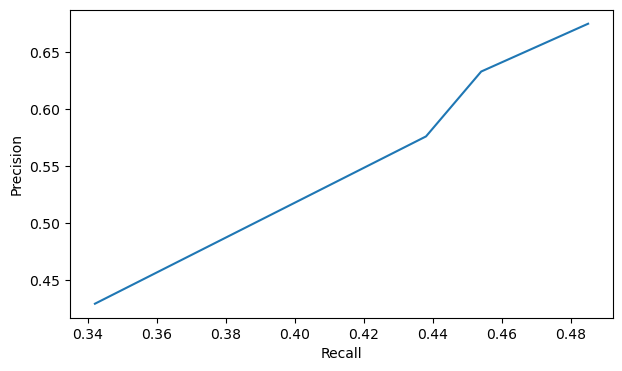

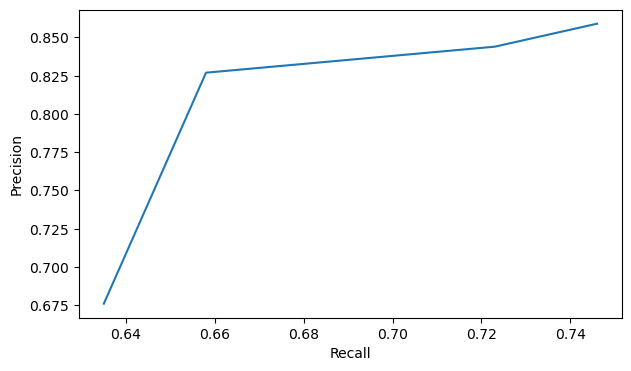

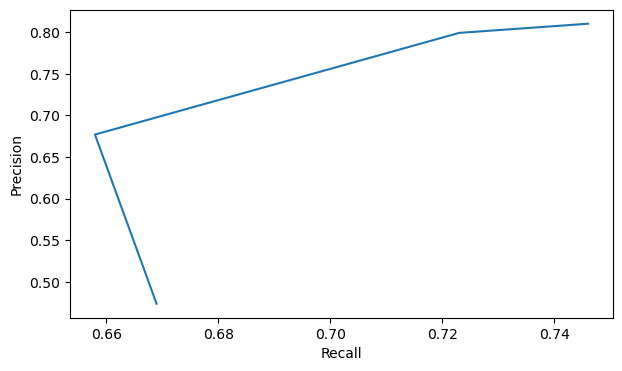

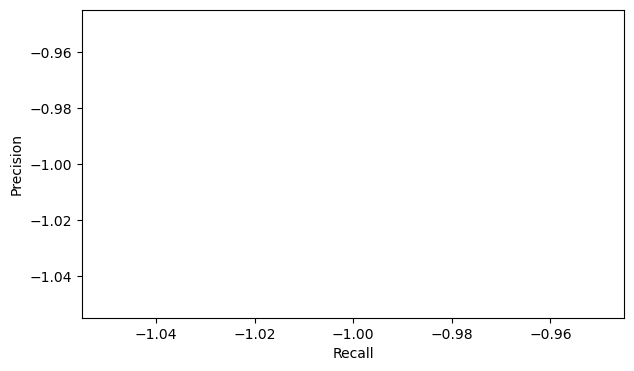

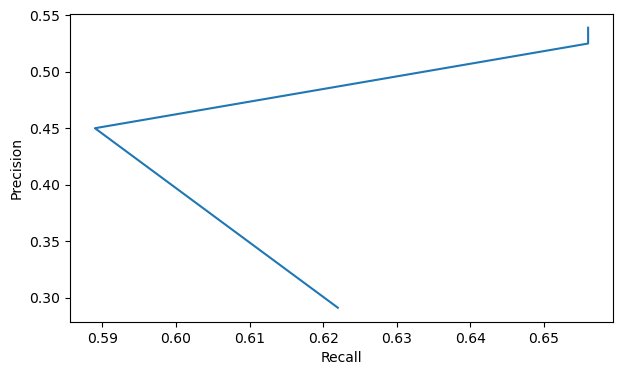

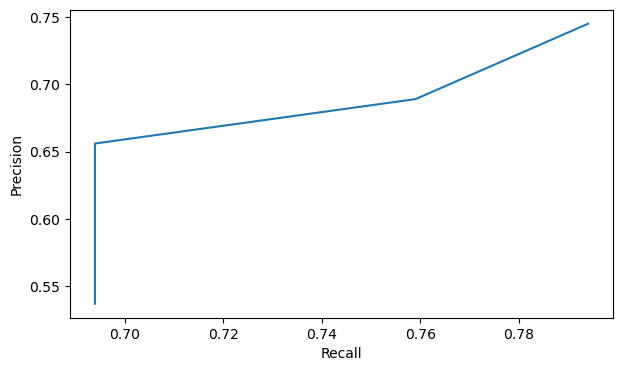

In [265]:
for i in range(len(AR_all[0])):
    x = []
    y = []
    for j in range(len(AR_all)):
        x.append(AR_all[j][i])
        y.append(AP_all[j][i])
    #print(x)
    #print(y)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(x,y)
    plt.show()

# Save model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
# Additional information

torch.save(model, '/scratch/ndillenb/trained_model_saved/4epoch_fixed4_27_03_2023.pt')

# Load model

In [9]:
model = torch.load('/scratch/ndillenb/trained_model_saved/10epoch_21_03_2023.pt')

# Show results

In [16]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index

In [17]:
from torchvision import transforms as torchtrans
from matplotlib import pyplot as plt
import matplotlib.patches as patches
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


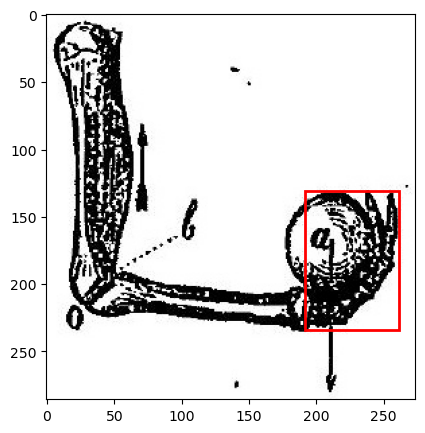

In [56]:
# pick one image from the test set
import random
#for i in range(10):
rnd = random.randrange(1,len(dataset_test))
img, target = dataset_test[rnd]
# put the model in evaluation mode
model.eval()
with torch.no_grad(): #Turn off gradient computation
    predictions = model([img.to(device)])[0]
print((predictions['masks'][0]))
#print(predictions)
#print(target)
#print('predicted #boxes: ', len(prediction['labels']))
#print('real #boxes: ', len(target['labels']))
plot_img_bbox(torch_to_pil(img), target)
plt.show()

# Plot view

In [269]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')


def get_prediction(img_path, confidence, disable_confidence):
    """
    get_prediction
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.

    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img).to(device)
    pred = model([img])
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    #print(np.max(pred_score))
    if disable_confidence:
        try:
            pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
        except IndexError:
            pred_t = [pred_score.index(x) for x in pred_score if x>=np.max(pred_score)][-1]
    else:
        try:
            pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
        except IndexError:
            return None, None, None
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=2, disable_confidence=False):
    """
    object_detection_api
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
    """
    boxes, pred_cls, pred_score = get_prediction(img_path, confidence, disable_confidence)
    if boxes == None:
        return None, None
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(len(boxes))
    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])), color=(255, 0, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i]+": "+str(round(pred_score[i],3)), (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return pred_score, boxes

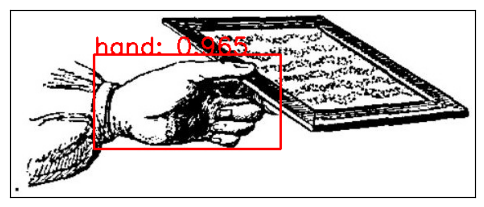

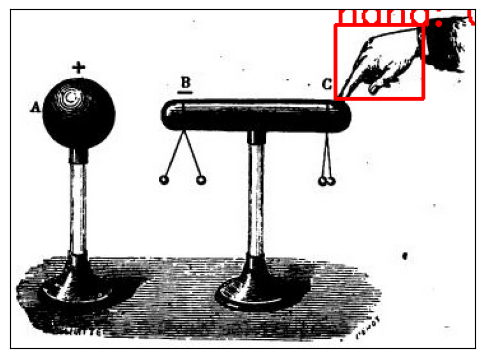

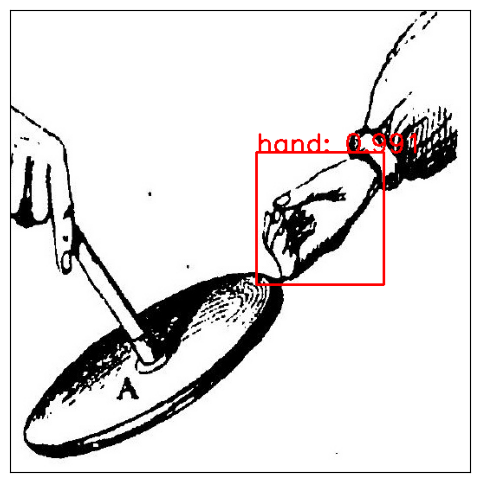

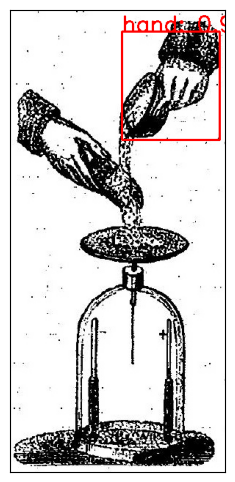

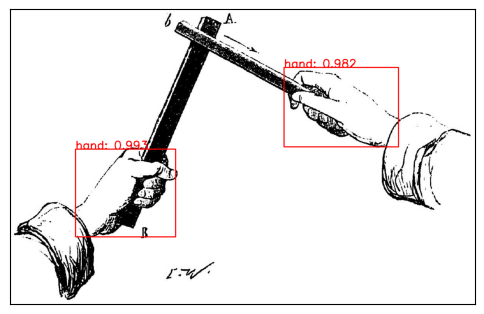

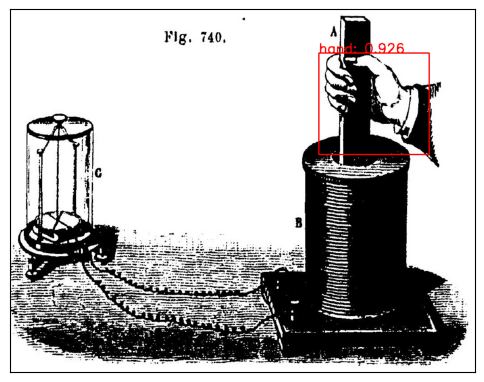

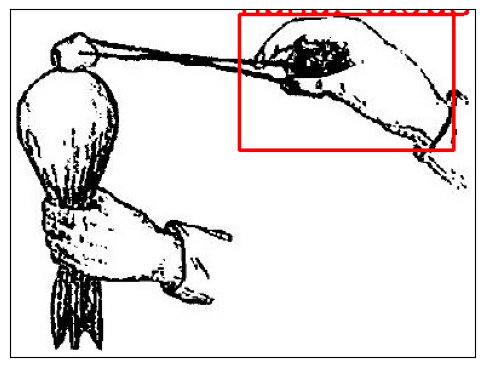

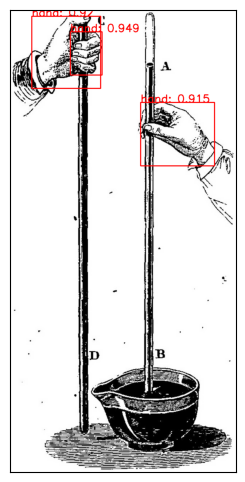

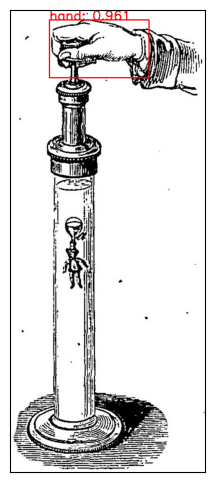

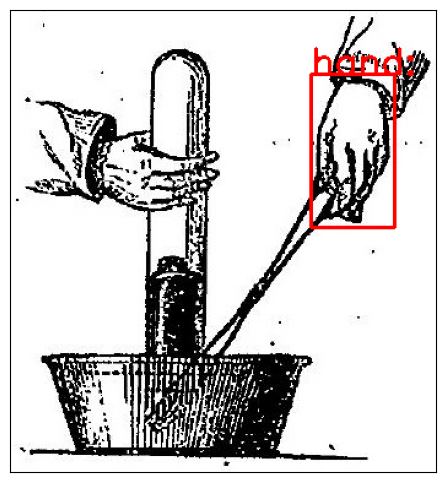

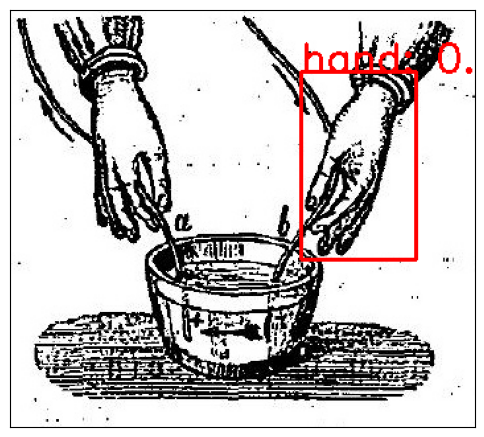

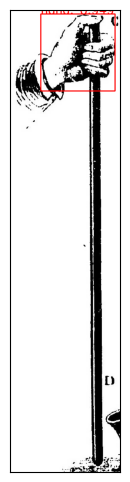

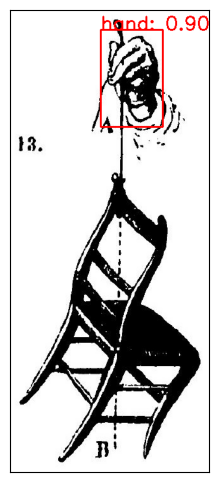

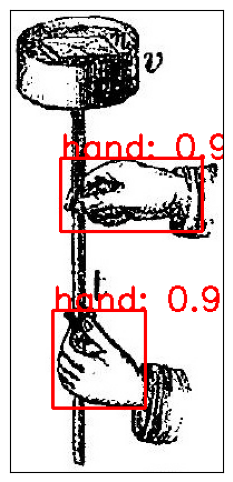

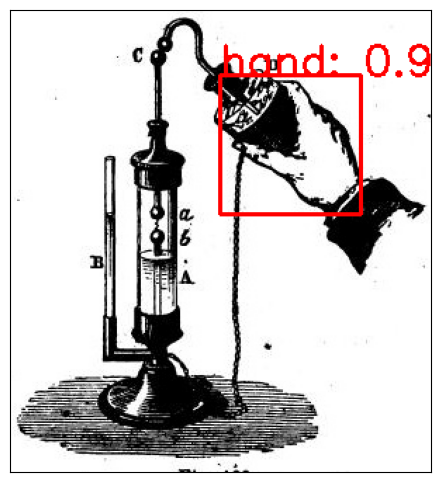

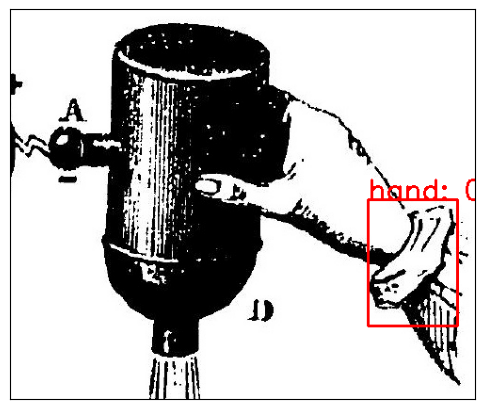

In [272]:
import os, random

CLASS_NAMES = ['__background__', 'hand']
folder = '/scratch/ndillenb/notebooks/Hand-Segmentation/Hands_dataset/PNGImages1/'
#file = random.choice(os.listdir(folder))
for image in dataset_test.indices:
    #f = open(os.path.join(det,sorted(os.listdir(folder))[image][:-4]+".txt"), "w")
    pred_score, boxes = detect_object((os.path.join(folder,sorted(os.listdir(folder))[image])),confidence=0.9,disable_confidence=False)

In [86]:
def get_max_conf():
    model.eval()
    CLASS_NAMES = ['__background__', 'hand']
    folder = '/scratch/ndillenb/notebooks/Hand-Segmentation/Hands_dataset/PNGImages1/'
    mean_samples = 10
    pred_score_total = 0
    for i in range(mean_samples):
        file = random.choice(os.listdir(folder)) 
        pred_score = detect_object((os.path.join(folder,file)),confidence=0.6)[0]
        pred_score_total = pred_score + pred_score_total
    return (pred_score_total/mean_samples)

# Plot Performance

In [139]:
import os, random
import matplotlib.pyplot as plt
num_epochs = 30
evalutaltion = []
x = range(num_epochs)
y = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    print('evaluate')
    # evaluate on the test dataset
    evalutaltion.append(evaluate(model, data_loader_test, device=device))
    y.append(get_max_conf())
    model.train()
print("That's it!")
plt.plot(x,y)
plt.show()

Epoch: [0]  [ 0/53]  eta: 0:03:25  lr: 0.000000  loss: 0.5265 (0.5265)  loss_classifier: 0.0824 (0.0824)  loss_box_reg: 0.1000 (0.1000)  loss_mask: 0.3107 (0.3107)  loss_objectness: 0.0247 (0.0247)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 3.8826  data: 3.4074  max mem: 4352


KeyboardInterrupt: 

from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#testing-forward-method-optional

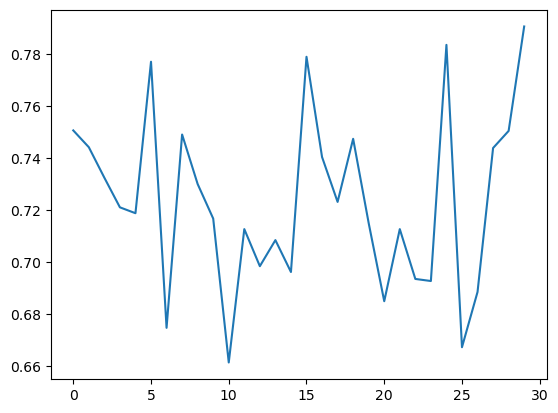

In [123]:
plt.plot(x,y)
plt.show()

# Split data into train/val

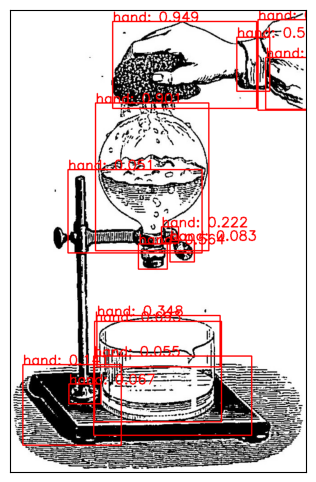

['hand 0.94931275 227 25 546 218\n', 'hand 0.9009133 189 206 440 534\n', 'hand 0.8288811 566 105 658 220\n', 'hand 0.69271135 187 691 468 914\n', 'hand 0.56658775 502 60 575 180\n', 'hand 0.56439537 284 519 348 575\n', 'hand 0.34775332 192 678 465 792\n', 'hand 0.30262646 549 21 658 222\n', 'hand 0.22245176 335 481 373 517\n', 'hand 0.14098866 28 787 246 966\n', 'hand 0.08310432 354 511 408 559\n', 'hand 0.06676251 130 830 201 874\n', 'hand 0.055134837 185 768 535 944\n', 'hand 0.050991815 128 354 425 539\n']


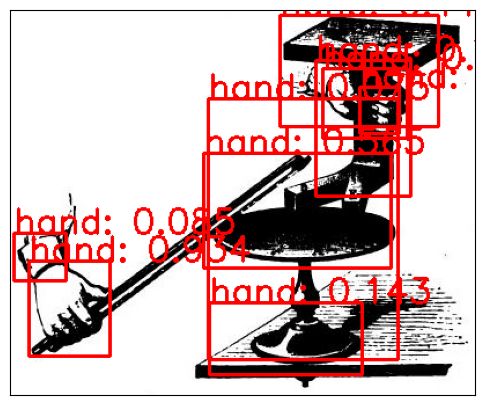

['hand 0.93427575 16 217 86 299\n', 'hand 0.63332736 270 51 343 111\n', 'hand 0.5648633 167 124 329 223\n', 'hand 0.16006841 302 67 336 107\n', 'hand 0.14322221 172 253 304 315\n', 'hand 0.118106835 233 5 370 101\n', 'hand 0.110464446 264 44 346 161\n', 'hand 0.08492609 3 193 48 234\n', 'hand 0.07491605 171 77 335 302\n']


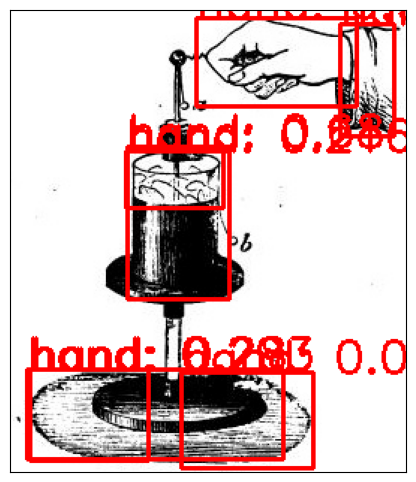

['hand 0.9834359 124 5 231 64\n', 'hand 0.68039095 78 91 146 193\n', 'hand 0.5696635 220 9 256 84\n', 'hand 0.29277894 11 240 182 300\n', 'hand 0.2797435 13 240 92 301\n', 'hand 0.21570022 77 94 142 132\n', 'hand 0.067142 114 242 202 306\n']


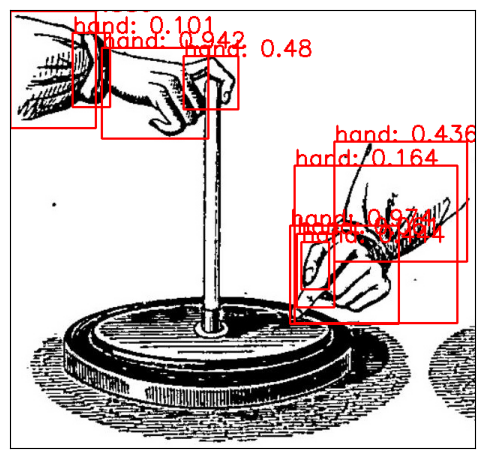

['hand 0.974101 373 287 518 418\n', 'hand 0.9424081 122 50 264 171\n', 'hand 0.88906515 0 1 114 157\n', 'hand 0.4797834 231 61 304 132\n', 'hand 0.44400954 388 309 425 372\n', 'hand 0.43556935 432 175 609 335\n', 'hand 0.16430187 379 207 596 417\n', 'hand 0.10114145 83 30 133 129\n', 'hand 0.06104397 382 298 432 396\n']


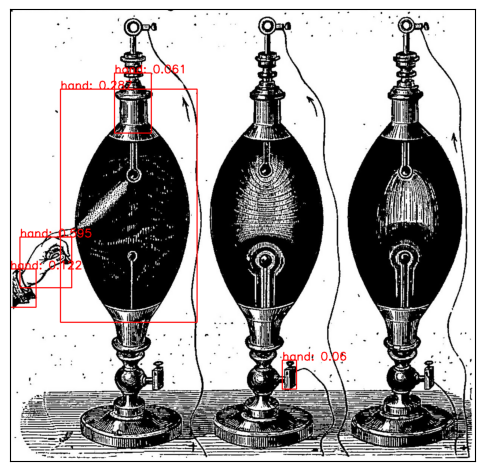

['hand 0.59534335 26 607 164 742\n', 'hand 0.28675902 134 213 498 834\n', 'hand 0.12176115 0 692 69 794\n', 'hand 0.061458603 278 170 376 330\n', 'hand 0.059586048 725 935 763 1012\n']


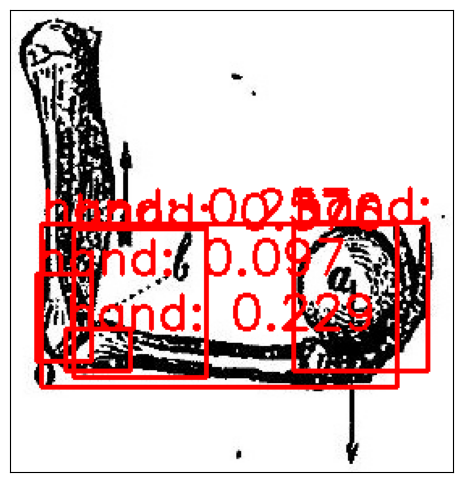

['hand 0.95271534 175 131 258 223\n', 'hand 0.37581748 39 135 121 227\n', 'hand 0.25702354 19 132 239 233\n', 'hand 0.22872247 34 197 74 223\n', 'hand 0.096901506 16 163 50 217\n']


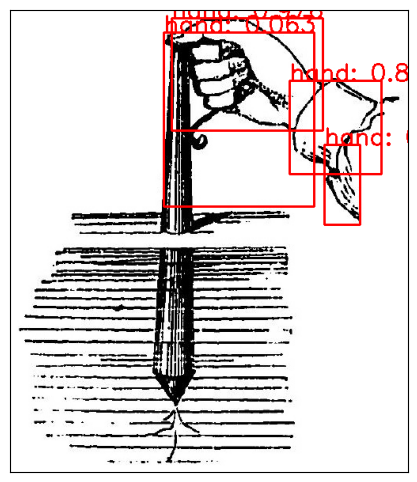

['hand 0.9759629 204 10 395 152\n', 'hand 0.89372575 353 89 469 207\n', 'hand 0.4998149 397 170 442 271\n', 'hand 0.0625455 194 28 384 248\n']


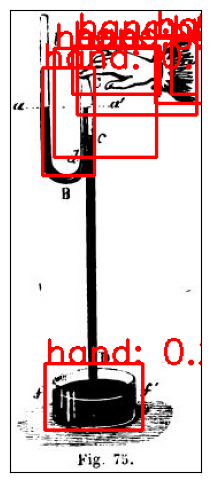

['hand 0.9071927 126 22 167 81\n', 'hand 0.84718233 54 31 130 73\n', 'hand 0.27837527 30 308 115 366\n', 'hand 0.19688883 28 50 73 144\n', 'hand 0.12071703 58 24 162 91\n', 'hand 0.08100572 140 26 162 73\n', 'hand 0.06581978 38 33 127 128\n']


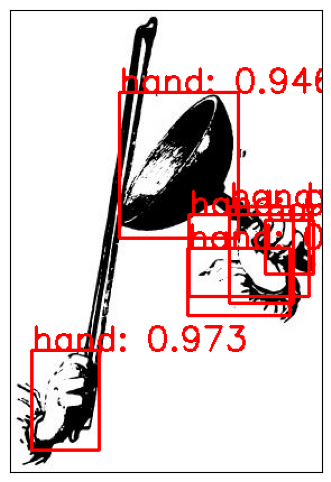

['hand 0.97285676 19 303 79 392\n', 'hand 0.9464818 97 73 203 203\n', 'hand 0.55441844 195 175 252 261\n', 'hand 0.36910307 159 182 266 255\n', 'hand 0.33454543 158 212 249 272\n', 'hand 0.08466503 227 187 270 235\n']


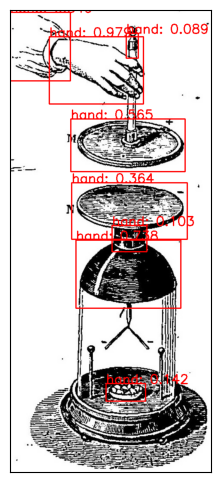

['hand 0.97925013 91 62 310 219\n', 'hand 0.7381849 153 537 397 696\n', 'hand 0.5649533 141 254 407 377\n', 'hand 0.5490033 0 5 140 165\n', 'hand 0.36426547 143 403 412 535\n', 'hand 0.14213747 223 872 315 913\n', 'hand 0.10288177 237 503 318 564\n', 'hand 0.088971764 270 54 298 112\n']


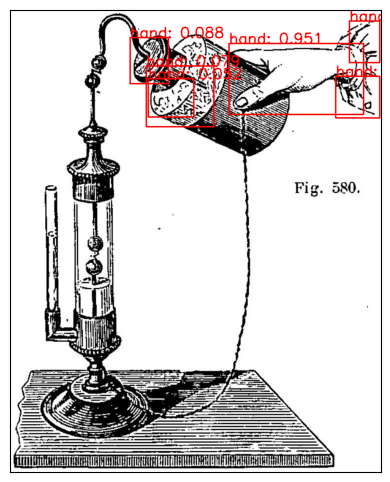

['hand 0.95093244 447 68 722 213\n', 'hand 0.22212526 665 135 755 220\n', 'hand 0.18348552 693 22 755 107\n', 'hand 0.087577365 245 56 323 150\n', 'hand 0.07922129 278 114 416 238\n', 'hand 0.05168551 282 140 375 218\n']


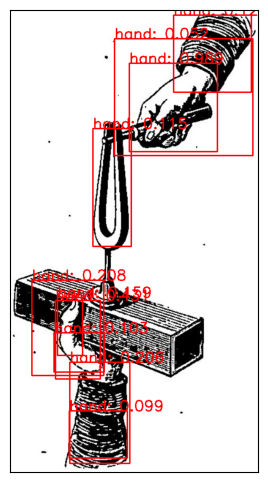

['hand 0.9892595 242 108 421 288\n', 'hand 0.43087092 92 591 183 751\n', 'hand 0.20797187 44 550 190 744\n', 'hand 0.20557943 121 717 243 923\n', 'hand 0.15861654 96 585 147 703\n', 'hand 0.12850936 332 10 490 167\n', 'hand 0.114797376 168 241 246 481\n', 'hand 0.102887295 89 657 191 737\n', 'hand 0.098514944 120 816 238 912\n', 'hand 0.051550847 212 58 493 296\n']


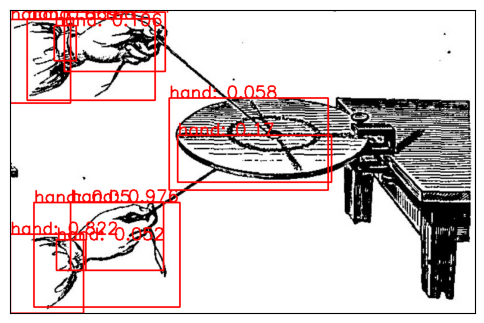

['hand 0.9760659 107 341 272 462\n', 'hand 0.97143745 96 5 275 110\n', 'hand 0.86932826 0 18 107 166\n', 'hand 0.8221219 0 398 130 538\n', 'hand 0.16951138 297 223 570 306\n', 'hand 0.10843423 30 17 257 161\n', 'hand 0.10630752 78 29 117 91\n', 'hand 0.057939034 282 157 564 320\n', 'hand 0.051704146 82 408 134 462\n', 'hand 0.05008129 42 342 301 527\n']


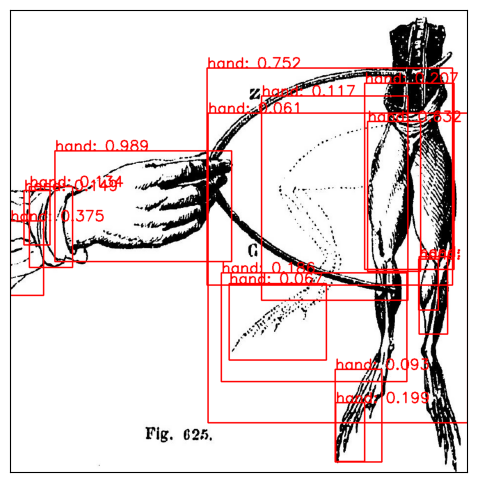

['hand 0.9890456 91 287 451 513\n', 'hand 0.75187385 401 118 901 561\n', 'hand 0.6322009 728 227 836 533\n', 'hand 0.4317336 832 508 872 612\n', 'hand 0.3750996 0 430 68 582\n', 'hand 0.20743816 722 149 904 529\n', 'hand 0.19921352 663 801 722 921\n', 'hand 0.18622705 430 536 808 758\n', 'hand 0.14946592 28 368 81 479\n', 'hand 0.1374761 833 503 891 661\n', 'hand 0.13399816 39 360 127 525\n', 'hand 0.117081925 512 175 810 592\n', 'hand 0.09326295 662 733 757 922\n', 'hand 0.06685426 446 558 644 714\n', 'hand 0.060594447 403 210 932 842\n']


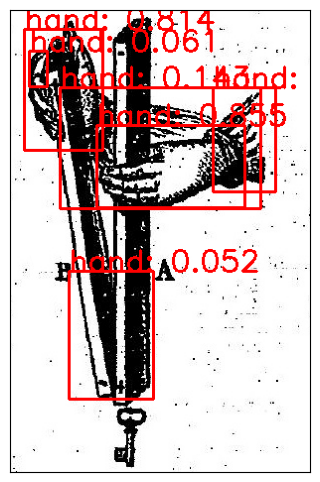

['hand 0.8548739 87 116 236 199\n', 'hand 0.81430125 14 19 93 141\n', 'hand 0.14308788 50 78 252 200\n', 'hand 0.061369542 204 78 267 183\n', 'hand 0.061256994 19 41 37 77\n', 'hand 0.051822197 59 263 144 392\n']


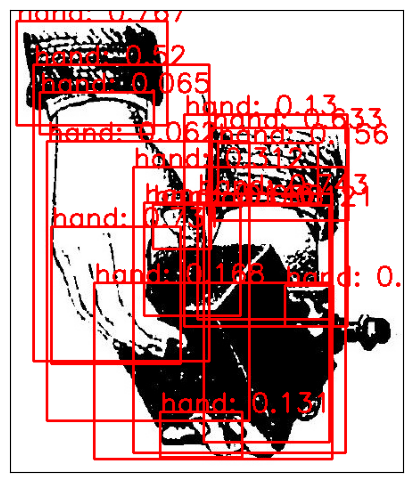

['hand 0.76664317 7 12 176 129\n', 'hand 0.74311894 210 206 361 347\n', 'hand 0.7312504 46 243 191 397\n', 'hand 0.6331551 226 132 379 236\n', 'hand 0.51969737 26 61 223 394\n', 'hand 0.31173047 138 176 376 497\n', 'hand 0.168415 94 306 361 504\n', 'hand 0.15559886 233 149 345 217\n', 'hand 0.14613628 150 216 258 343\n', 'hand 0.13109611 168 451 260 502\n', 'hand 0.1301562 195 117 378 355\n', 'hand 0.121034846 217 219 358 485\n', 'hand 0.088378094 160 218 225 268\n', 'hand 0.085411176 308 309 362 355\n', 'hand 0.06532291 33 92 161 139\n', 'hand 0.06227545 41 147 268 461\n']


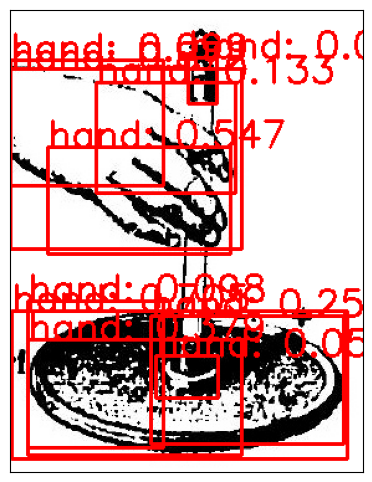

['hand 0.872026 0 47 186 192\n', 'hand 0.7053274 1 242 271 361\n', 'hand 0.54748607 30 110 177 196\n', 'hand 0.37877455 14 265 186 358\n', 'hand 0.25038344 113 246 268 349\n', 'hand 0.13337974 69 58 181 147\n', 'hand 0.09861184 0 40 123 141\n', 'hand 0.09849445 14 234 123 352\n', 'hand 0.06593952 143 38 166 75\n', 'hand 0.057436988 117 278 167 312\n']


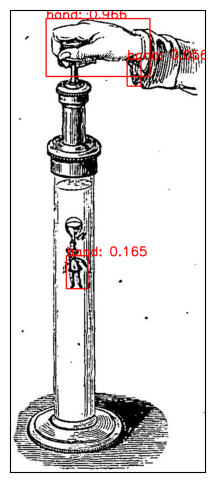

['hand 0.96617484 85 20 331 157\n', 'hand 0.16478696 133 582 184 660\n', 'hand 0.0564214 277 116 310 180\n']


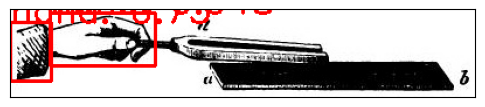

['hand 0.9475605 34 3 124 48\n', 'hand 0.7302482 0 11 35 61\n']


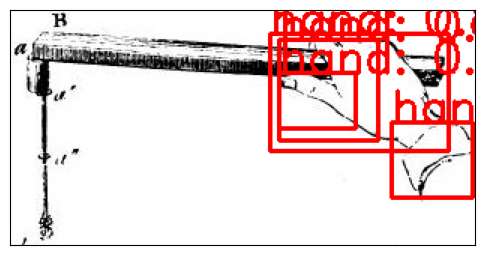

['hand 0.89711523 173 16 292 94\n', 'hand 0.747443 254 75 308 125\n', 'hand 0.4151851 179 20 245 87\n', 'hand 0.3059195 179 42 230 79\n']


In [87]:
import os, random
import shutil
gts = 'metrics/gts'
det = 'metrics/det'
img = 'metrics/img'
CLASS_NAMES = ['__background__', 'hand']
folder = '/scratch/ndillenb/notebooks/Hand-Segmentation/Hands_dataset/PNGImages1/'
for image in dataset_test.indices:
    f = open(os.path.join(det,sorted(os.listdir(folder))[image][:-4]+".txt"), "w")
    pred_score, boxes = detect_object((os.path.join(folder,sorted(os.listdir(folder))[image])),confidence=0)
    text = []
    for i in range(len(boxes)):
        text.append('hand '+ str(pred_score[i])+ ' '+ str(int(boxes[i][0][0]))+ ' '+str(int(boxes[i][0][1]))+ ' '+ str(int(boxes[i][1][0]))+ ' '+ str(int(boxes[i][1][1]))+'\n')
    print(text)
    f.writelines(text)
    f.close
    #print(boxes)
    #print(pred_score[0])
for i in range(len(dataset_test.indices)):
    f = open(os.path.join(gts,sorted(os.listdir(folder))[i][:-4]+".txt"), "w")
    image, target = dataset_test[i]
    text = []
    for element in target['boxes']:
        text.append('hand ' + str(int(element[0])) +' ' + str(int(element[1])) +' '+str(int(element[2])) +' '+str(int(element[3]))+'\n')
    f.writelines(text)
    f.close
for i in range(len(dataset_test.indices)):
    shutil.copyfile((os.path.join(folder,sorted(os.listdir(folder))[i])), (os.path.join(img,sorted(os.listdir(folder))[i])))

In [122]:
for i in range(len(dataset_test.indices)):
    #f = open(os.path.join(gts,sorted(os.listdir(folder))[i][:-4]+".txt"), "w")
    image, target = dataset_test[i]
    text = []
    for element in target['boxes']:
        text.append('hand ' + str(int(element[0])) +' ' + str(int(element[1])) +' '+str(int(element[2])) +' '+str(int(element[3])))
    print(text)
    #f.writelines(text)
    #f.close

['hand 344 131 423 255', 'hand 352 158 416 232']
['hand 229 22 527 169', 'hand 239 31 496 127']
['hand 192 7 396 153', 'hand 199 23 319 144']
['hand 24 3 362 230', 'hand 24 23 352 226', 'hand 26 146 140 225']
['hand 208 62 225 83']
['hand 33 46 122 129']
['hand 4 4 218 141', 'hand 22 23 208 79']
['hand 56 40 295 189', 'hand 56 43 271 178', 'hand 58 47 120 168']
['hand 54 58 231 141', 'hand 118 63 208 128']
['hand 74 0 282 113', 'hand 76 1 240 86', 'hand 78 2 156 84']
['hand 108 285 455 492', 'hand 111 320 452 480']
['hand 200 146 282 279', 'hand 207 156 264 272']
['hand 208 43 798 516', 'hand 208 47 784 516', 'hand 210 346 330 514']
['hand 85 243 307 417', 'hand 175 259 264 368']
['hand 30 579 175 743', 'hand 31 615 96 711']
['hand 368 36 617 141', 'hand 383 39 608 128']
['hand 531 355 672 597', 'hand 551 399 660 584']
['hand 346 23 588 135']
['hand 411 220 1090 615', 'hand 412 223 1080 592', 'hand 413 224 581 439']
['hand 16 170 263 391', 'hand 22 191 248 391', 'hand 23 306 76 389']


In [98]:
import random
import os
import shutil

TRAIN = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/train'
TRAIN_MASKS = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/train_mask'
VAL = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/val'
VAL_MAKS = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/val_mask'
EVERYTHING = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/everything'
EVERYTHING_MASKS = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/everything_masks'
for i in dataset.indices: 
    shutil.copyfile(os.path.join(EVERYTHING,sorted(os.listdir(EVERYTHING))[i]), os.path.join(TRAIN,sorted(os.listdir(EVERYTHING))[i]))
    shutil.copyfile(os.path.join(EVERYTHING_MASKS,sorted(os.listdir(EVERYTHING_MASKS))[i]), os.path.join(TRAIN_MASKS,sorted(os.listdir(EVERYTHING_MASKS))[i]))
for i in dataset_test.indices: 
    shutil.copyfile(os.path.join(EVERYTHING,sorted(os.listdir(EVERYTHING))[i]), os.path.join(VAL,sorted(os.listdir(EVERYTHING))[i]))
    shutil.copyfile(os.path.join(EVERYTHING_MASKS,sorted(os.listdir(EVERYTHING_MASKS))[i]), os.path.join(VAL_MAKS,sorted(os.listdir(EVERYTHING_MASKS))[i]))